In [1]:
# public packages
import andes
import ams
import cvxpy as cp
import numpy as np
import gurobipy
import os
import matplotlib.pyplot as plt
%matplotlib inline

# local packages
import anci_fun as af


# include dynamic constraints using reduced input/output NN model

# ------ nn information ------
# input:   [M, D]
# output:  [rocof_max, fnadir, dtheta_max]
# nn_diam: [16, ..., 3]

# Para preparetion

In [2]:
# neural network parameters 
nn_name = 'NN_16_64_3.pth'
nn_weights, nn_bias, nn_diam = af.extract_nn_para(nn_name)

In [3]:
# MD parameters
vsg_num = 8

# lb_M = np.ones([vsg_num])*0.1
lb_M = np.array([0.02208462, 0.00709857, 0.06479399, 0.05698404, 0.07926447, 0.06375611, 0.0636579 , 0.16812373])
ub_M = np.ones([vsg_num])*6

# lb_D = np.ones([vsg_num])*0.1
lb_D = np.array([0.11814667, 0.06732237, 0.58718068, 0.54605445, 0.37454199, 0.41813483, 0.51832465, 0.55060247])
ub_D = np.ones([vsg_num])*4


In [4]:
# y = [rocof_max, fnadir, dtheta_max]
lb_y = np.array([-0.5, -0.6, -3.14])
ub_y = np.array([ 0.5,  0.6,  3.14])

# Load ams model

In [5]:
ssp = ams.load('ams_case123_REGCV1_v7.xlsx')

ssp.LDOPF.run()

ssp.LDOPF.om.mdl.solve()

ssp.LDOPF.om.vars

LDOPF solved as optimal in 0.1255 seconds with exit code 0.


OrderedDict([('pg', Variable((11,))),
             ('pn', Variable((117,))),
             ('qg', Variable((11,))),
             ('qn', Variable((117,))),
             ('vsq', Variable((117,))),
             ('pl', Variable((116,))),
             ('ql', Variable((116,)))])

In [6]:
# ssp.LDOPF.pg.get_idx()

# Define new variables, constraints, and obj

In [7]:
# M and D

M = cp.Variable(vsg_num, name="M")
D = cp.Variable(vsg_num, name="D")

M_coeff = np.ones((vsg_num))
D_coeff = np.ones((vsg_num))

constraints_M = [M >= lb_M, M <= ub_M]
constraints_D = [D >= lb_D, D <= ub_D]

In [8]:
# data for the neural network linearization
pg    = ssp.LDOPF.om.pg

x1    = cp.hstack([M, D])  # this version doesn't incelu load scaling factor

w1    = nn_weights[0]
w2    = nn_weights[1]

b1    = nn_bias[0]
b2    = nn_bias[1]

hdown = -100
hup   = 100

In [9]:
# neural network linization

z = cp.Variable(nn_diam[1], name="z")
a = cp.Variable(nn_diam[1], name="a", boolean=True)

z_ = w1 @ x1 + b1

y = w2 @ z + b2

constraints_nn = [
                    # linization constraints
                    z <= z_ - hdown * (1 - a),
                    z >= z_,
                    z <= hup * a,
                    z >= 0,
                    # output constraints
                    y <= ub_y,
                    y >= lb_y,
                    # M @ M_coeff >= 3.1*vsg_num,
                    # D @ D_coeff >= 1.02*vsg_num
                    # y[0] <= ub_y[0],         # RoCoF
                    # y[0] >= lb_y[0],
                    # y[1] <= ub_y[1],         # fnadir
                    # y[1] >= lb_y[1],
                    # y[2] <= ub_y[2],         # dtheta_max
                    # y[2] >= lb_y[2],     
                ]

In [10]:
# extract original ams constraints
constriants_ams = [ssp.LDOPF.om.constrs[cname] for cname in ssp.LDOPF.om.constrs.keys()]

In [11]:
constraints = constraints_M + constraints_D + constraints_nn + constriants_ams

# constraints = constriants_ams + constraints_M + constraints_D

# Formulate new problem

pg = ['PV_1',
 'PV_2',
 'PV_3',
 'PV_4',
 'PV_5',
 'PV_6',
 'PV_7',
 'PV_8',
 'PV_9',
 'PV_10',
 'PV_11']

 SG: PV_1, PV_2, PV_3 (slack bus)

 IBR: PV_4, PV_5, ..., PV_11

In [12]:
c2 = np.array([0.01, 0.01, 0.02, 0, 0, 0, 0, 0, 0, 0, 0])
c1 = np.array([  20, 20,   30,   0, 0, 0, 0, 0, 0, 0, 0])

# d  = np.array([0, 0, 0, 0.01, 0, 0, 0.001, 0])
c_M  = np.array([3, 4, 1, 1, 2, 1, 1, 1])

c_D  = np.array([2, 3, 1, 1, 1.5, 1, 1, 1])

pg_power = pg**2

cost = cp.sum(c2 @ pg_power + c1 @ pg + c_M @ M + c_D @ D)

obj = cp.Minimize(cost)

In [13]:
# Create the optimization problem
prob = cp.Problem(obj, constraints)

# Solve the optimization problem

# prob.solve(solver=cp.GUROBI, verbose=True)
prob.solve(solver=cp.GUROBI)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-13


31.81683432499694

In [14]:
prob.status

'optimal'

In [15]:
ssp.LDOPF.om.pg.value

array([0.175 , 0.315 , 0.2695, 0.07  , 0.084 , 0.049 , 0.042 , 0.063 ,
       0.0525, 0.056 , 0.0595])

In [16]:
M.value

array([0.02208462, 0.00709857, 0.06479399, 0.05698404, 1.39874911,
       0.06375611, 6.        , 1.03669843])

In [17]:
D.value

array([0.11814667, 0.06732237, 0.58718068, 0.54605445, 0.37454199,
       0.61246861, 0.51832465, 0.55060247])

# TDS validation

## load case

In [18]:
andes.config_logger(stream_level=20)

# case path
dir_path = os.path.abspath('..')
loc_path_case = '/main_vis_gurobi_v7/case123_REGCV1_v7.xlsx'

case = dir_path + loc_path_case

# load a case
ssa = andes.load(case,
                 setup=True,
                 no_output=True)

Working directory: "/Users/buxinshe/Documents/git-repo/andes/bshe/Stability_VIS/ams_for_vis/main_vis_gurobi_v7"
> Loaded config from file "/Users/buxinshe/.andes/andes.rc"
> Loaded generated Python code in "/Users/buxinshe/.andes/pycode".
Parsing input file "/Users/buxinshe/Documents/git-repo/andes/bshe/Stability_VIS/ams_for_vis/main_vis_gurobi_v7/case123_REGCV1_v7.xlsx"...
Input file parsed in 0.0577 seconds.
System internal structure set up in 0.0207 seconds.


In [19]:
# reset REGCV1 control parameters
ssa.REGCV1.set(
                src='M', 
                idx= ssa.REGCV1.idx.v,
                attr='v',
                value= M.value
            )

ssa.REGCV1.set(
                src='D', 
                idx= ssa.REGCV1.idx.v, 
                attr='v',
                value= D.value
            )

True

In [20]:
ssa.PFlow.run()

ssa.TDS.init()

# Turn off stability check in TDS
ssa.TDS.config.criteria = 0

# Turn off simulation progress bar
ssa.TDS.config.no_tqdm = 1

# Simulation time
ssa.TDS.config.tf = 10

ssa.TDS.run()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0036 seconds.
0: |F(x)| = 0.65
1: |F(x)| = 0.003876638309
2: |F(x)| = 1.566892639e-05
3: |F(x)| = 8.199951829e-11
Converged in 4 iterations in 0.0041 seconds.
Initialization for dynamics completed in 0.0271 seconds.
Initialization was successful.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-10 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


<Toggle Toggler_1>: GENROU.GENROU_2 status changed to 0 at t=2.0 sec.


Simulation to t=10.00 sec completed in 0.7273 seconds.


True

# Plot TDS result

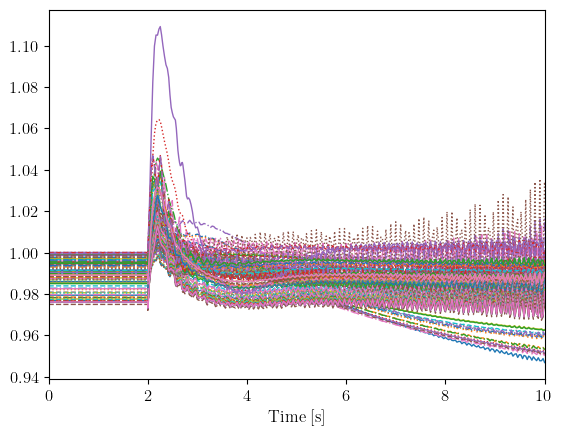

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Time [s]'>)

In [21]:
ssa.TDS.plt.plot(
                ssa.Bus.v,
                )

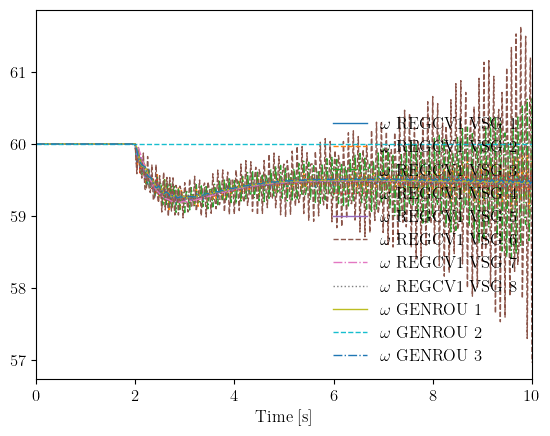

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Time [s]'>)

In [22]:
ssa.TDS.plt.plot(
                [ssa.REGCV1.omega, ssa.GENROU.omega],
                ytimes = 60,
                legend = True
                )

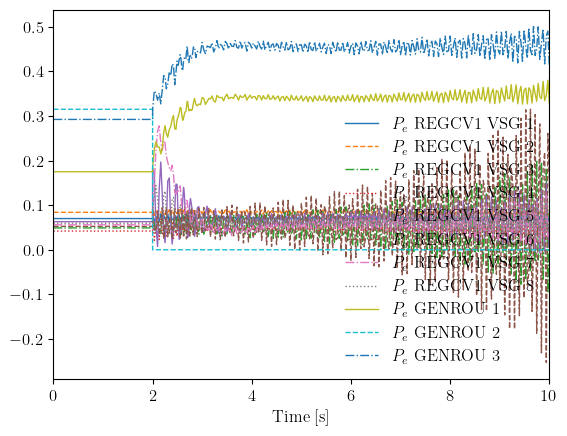

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Time [s]'>)

In [23]:
ssa.TDS.plt.plot(
                [ssa.REGCV1.Pe, ssa.GENROU.Pe],
                # left = 0.5,
                # right = 5,
                legend = True
                )

# Extract data

In [24]:
# Extract time
t = ssa.dae.ts.t
t = t[:, np.newaxis]

# Extract RoCoF
rocof     = ssa.dae.ts.y[:,  ssa.BusROCOF.Wf_y.a]
rocof_sg  = rocof[:, [0,1,2]]
rocof_ibr = rocof[:, [3,4,5,6,7,8,9,10]]
rocof_max = np.max(np.abs(rocof*60))

# Extract frequency
f         = ssa.dae.ts.x[:,  ssa.GENROU.omega.a]
fnadir    = np.min(f)*60 - 60

# Extract voltage
busV      = ssa.dae.ts.y[:,  ssa.Bus.v.a]
busV_min  = np.min(busV)

# Extract power angle
theta           = ssa.dae.ts.y[:, ssa.GENROU.a.a]
delta_theta     = np.max(theta, axis=1) - np.min(theta, axis=1)
delta_theta_max = np.max(delta_theta)

## Plot RoCoF

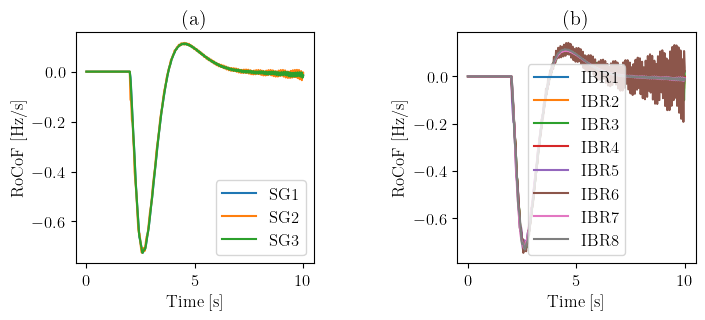

In [25]:
fig = plt.figure(figsize=(8, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.6, hspace=0.3)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ibr_legend = ['IBR1','IBR2','IBR3','IBR4','IBR5','IBR6','IBR7','IBR8']
sg_legend = ['SG1', 'SG2', 'SG3']

ax1.plot(
            t,
            rocof_sg * 60,
        )
ax1.set_title('(a)')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('RoCoF [Hz/s]')
ax1.legend(sg_legend)
# ax1.set_ylim([0.95, 1.12])
# ax1.set_xlim([0, 3600])

ax2.plot(
            t,
            rocof_ibr * 60,
        )
ax2.set_title('(b)')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('RoCoF [Hz/s]')
ax2.legend(ibr_legend)

# 